In [1]:
# Modified from https://github.com/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb

# Try UnSAMv2 on Video Segmentation at any granularity!

## Set-up

In [11]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import imageio

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/unsamv2_plus_ckpt.pt" # your path to the checkpoint
model_cfg = "configs/unsamv2_small.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

Applying LoRA to UnSAMv2...
Successfully applied LoRA to UnSAMv2.


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

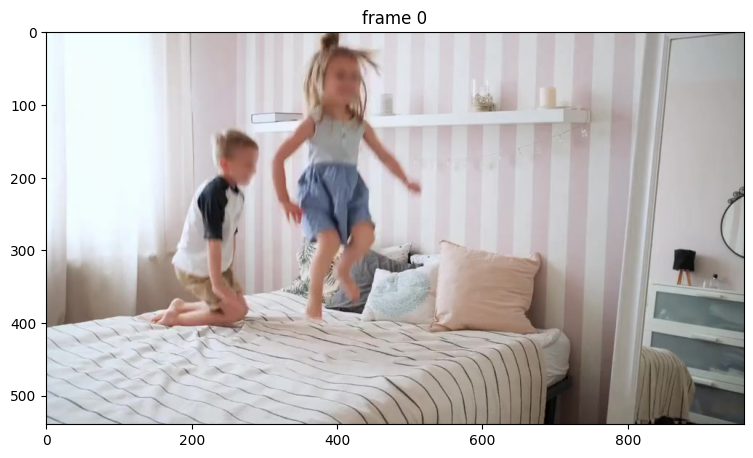

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [7]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 31.68it/s]


In [8]:
predictor.reset_state(inference_state)

#### Step 1: Add a click and granularity value on a frame

/home/yujunwei/UnSAMv2/sam2/sam2/sam2_video_predictor.py:796: UserWarning: /home/yujunwei/UnSAMv2/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


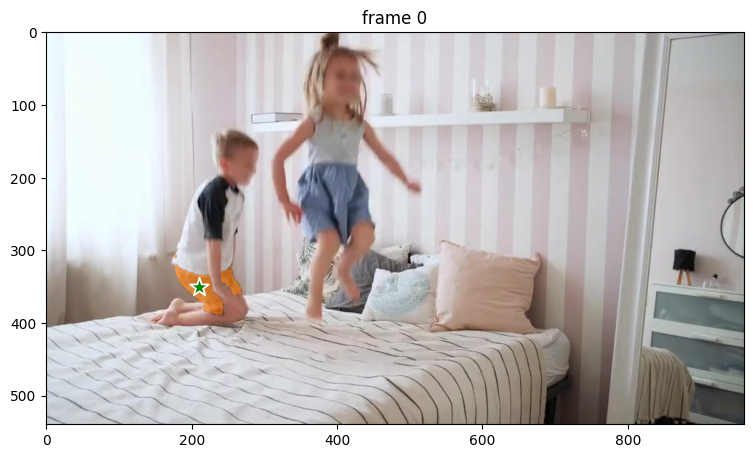

In [9]:
predictor.reset_state(inference_state)
granularity = 0.33 # try different granularity levels from [0.1, 1.0]!
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
predictor.reset_state(inference_state)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    gra=0.33,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > -1.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Propagate the prompts to get the masklet across the video

In [12]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, gra=granularity):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > -1.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Create frames for GIF with granularity text
gif_frames = []
plt.close("all")

# Extract granularity value for display
gra_value = granularity

# Process ALL frames
for out_frame_idx in range(len(frame_names)):
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f"frame {out_frame_idx}")
    ax.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    
    # Add masks for all objects
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, ax, obj_id=out_obj_id)
    
    # Add granularity text at the bottom
    ax.text(0.5, 0.02, f'Granularity: {granularity:.1f}', 
            transform=ax.transAxes, 
            fontsize=12, 
            color='white', 
            weight='bold',
            ha='center', 
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Remove axes for cleaner look
    ax.axis('off')
    
    # Convert matplotlib figure to PIL Image
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buffer = fig.canvas.buffer_rgba()
    img = Image.frombuffer('RGBA', (w, h), buffer, 'raw', 'RGBA', 0, 1).convert('RGB')
    gif_frames.append(img)
    
    plt.close(fig)  # Close figure to save memory

# Save as GIF with granularity value in filename
output_gif_path = f"./output_segmentation_gra_{gra_value:.1f}.gif"
imageio.mimsave(output_gif_path, gif_frames, duration=0.1)  # 0.1 seconds per frame
print(f"GIF saved to: {output_gif_path}")

propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]/home/yujunwei/UnSAMv2/sam2/sam2/sam2_video_predictor.py:796: UserWarning: /home/yujunwei/UnSAMv2/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 200/200 [00:09<00:00, 21.89it/s]


GIF saved to: ./output_segmentation_gra_0.3.gif


propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]/home/yujunwei/UnSAMv2/sam2/sam2/sam2_video_predictor.py:796: UserWarning: /home/yujunwei/UnSAMv2/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 200/200 [00:09<00:00, 22.17it/s]


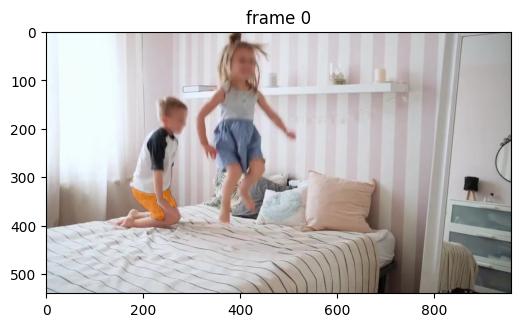

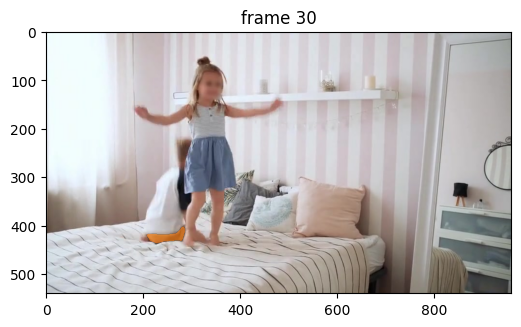

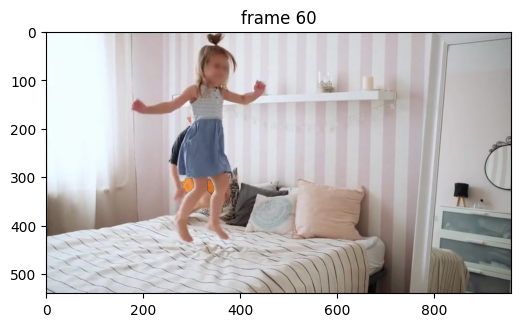

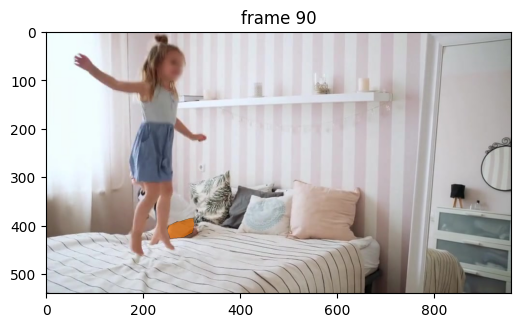

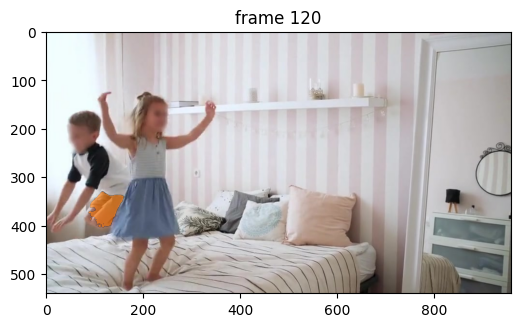

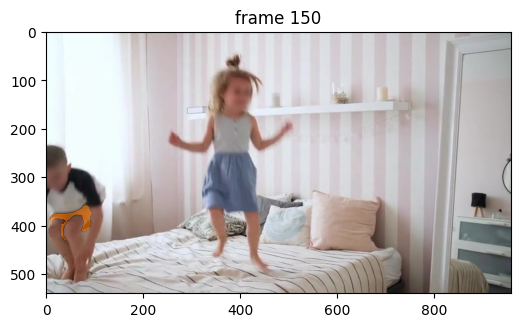

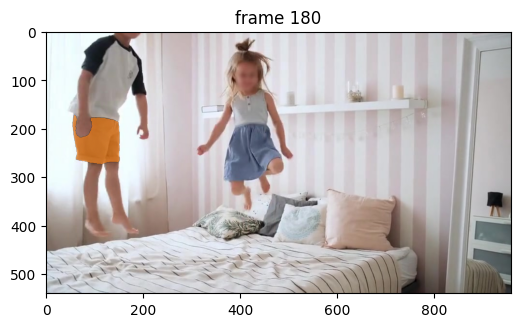

In [11]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, gra=granularity):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > -1.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)